# Donald Trump Twitter Topic Modeling

To find out what is on American President Donald Trump's mind in the COVID-19 pandemic, we gathered his original tweets (i.e. no retweet of others) posted from March 1 to April 27, 2020, and analyzed topics of the tweets by using Latent Dirichlet Allocation (LDA), a generative, probabilistic model for topic clustering/modeling. 

## Twitter Scrape

Import standard python libraries and twitterscraper

In [1]:
from twitterscraper import query_tweets
import datetime 
import pandas as pd
import re, pickle, os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

In [2]:
KEYWORD = 'realDonaldTrump'   #Twitter handle  
BEGINDATE = datetime.date(2020, 3, 1)
ENDDATE = datetime.date(2020, 4, 27)       
LANG = 'en'
TWEET_QUERY = 'from:'+ KEYWORD
ORIG_TWEET_FILE = r'./data/'+ KEYWORD+'/' + 'all_tweets'

Scrape twitter or load from a saved file

In [3]:
if os.path.isfile(ORIG_TWEET_FILE):        
    with open (ORIG_TWEET_FILE, 'rb') as fp:
        all_tweets_df = pickle.load(fp)
    print('Loaded tweet extracts from file\n')
else:
    print('Start scraping tweets from twitter.com...\n')
    # https://twitter.com/search-advanced
    list_of_tweets = query_tweets(TWEET_QUERY, 
                                  begindate=BEGINDATE, 
                                  enddate=ENDDATE, 
                                  lang=LANG)
    # Convert list of tweets to DataFrame
    all_tweets_df = pd.DataFrame([vars(x) for x in list_of_tweets])
    all_tweets_df.drop_duplicates(subset=['id'], inplace=True)
    all_tweets_df.reset_index(drop=True, inplace=True)
    # Save tweet extracts to file
    save_data_to_pickle(ORIG_TWEET_FILE, all_tweets_df)
    print ('Tweet extracts saved\n')   

Loaded tweet extracts from file



In [4]:
all_tweets_df.head(3)

,fullname,html,id,likes,replies,retweets,text,timestamp,url,user
0,Donald J. Trump,"<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en"">WOW! Thank you, just landed, see everyone soon! <a class=""twitter-hashtag pretty-link js-nav"" data-query-source=""hashtag_click"" dir=""ltr"" href=""/hashtag/KAG2020?src=hash""><s>#</s><b>KAG2020</b></a><img alt=""🇺🇸"" aria-label=""Emoji: Flag of United States"" class=""Emoji Emoji--forText"" draggable=""false"" src=""https://abs.twimg.com/emoji/v2/72x72/1f1fa-1f1f8.png"" title=""Flag of United States""/><a class=""twitter-timeline-link u-hidden"" data-pre-embedded=""true"" dir=""ltr"" href=""https://t.co/QGdfIsOp4u"">pic.twitter.com/QGdfIsOp4u</a></p>",1234615984880640001,88645,6464,18971,"WOW! Thank you, just landed, see everyone soon! #KAG2020pic.twitter.com/QGdfIsOp4u",2020-03-02 23:06:03,/realDonaldTrump/status/1234615984880640001,realDonaldTrump
1,Donald J. Trump,"<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en"">Departing for the Great State of North Carolina!<a class=""twitter-timeline-link u-hidden"" data-pre-embedded=""true"" dir=""ltr"" href=""https://t.co/BjnyTnnHUt"">pic.twitter.com/BjnyTnnHUt</a></p>",1234596295324717060,57495,4443,10456,Departing for the Great State of North Carolina!pic.twitter.com/BjnyTnnHUt,2020-03-02 21:47:49,/realDonaldTrump/status/1234596295324717060,realDonaldTrump
2,Donald J. Trump,"<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en"">They are staging a coup against Bernie!</p>",1234592543821705219,148456,23595,26949,They are staging a coup against Bernie!,2020-03-02 21:32:54,/realDonaldTrump/status/1234592543821705219,realDonaldTrump


Text(0.5, 0, 'Hour')

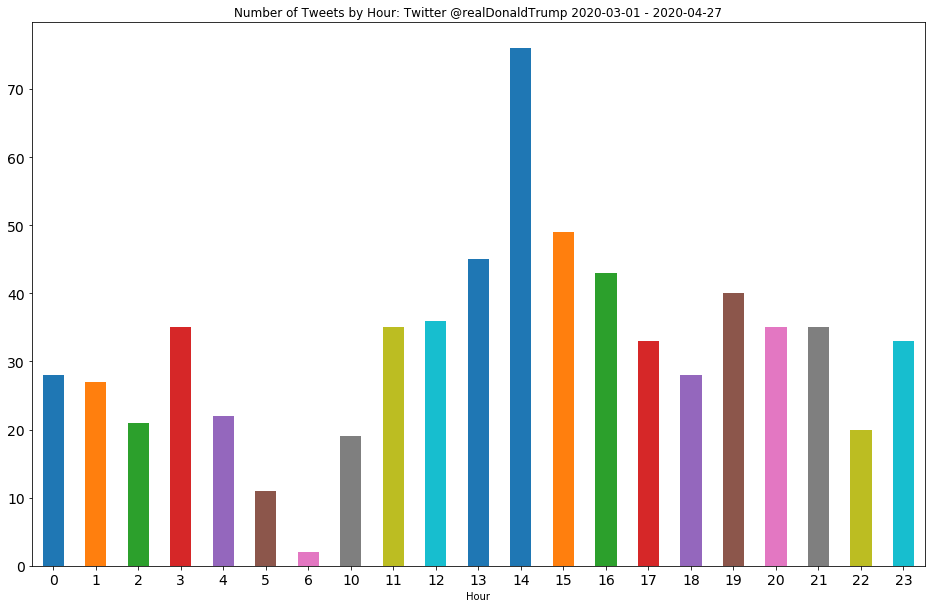

In [5]:
title = "Number of Tweets by Hour: Twitter @{} {} - {}".format(KEYWORD, BEGINDATE, ENDDATE)
all_tweets_df['id'].groupby(all_tweets_df["timestamp"].dt.hour).count().plot(figsize=(16,10), fontsize=14, kind='bar', rot=0, title=title)
plt.xlabel("Hour")

Text(0.5, 0, 'Day of Week')

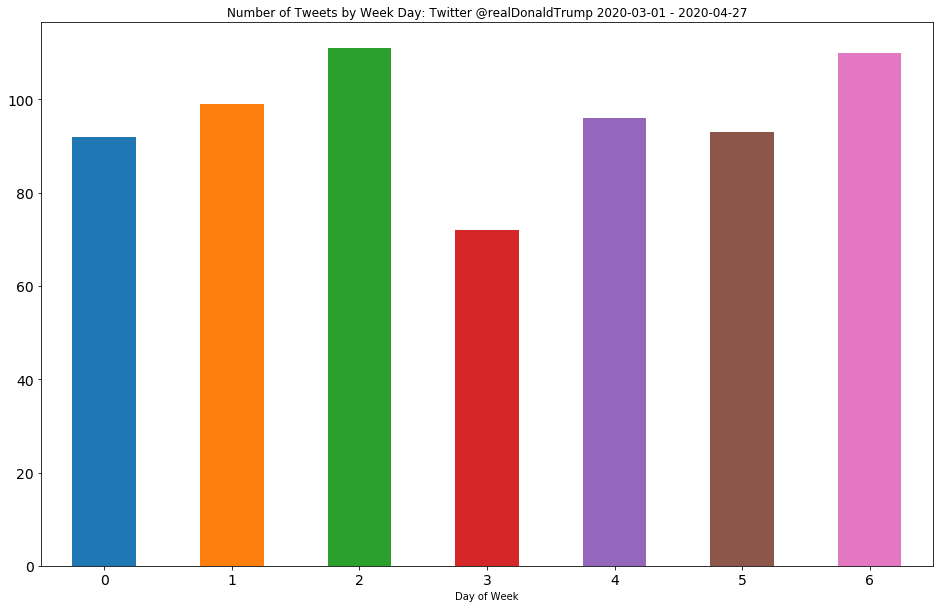

In [6]:
title = "Number of Tweets by Week Day: Twitter @{} {} - {}".format(KEYWORD, BEGINDATE, ENDDATE)
all_tweets_df['id'].groupby(all_tweets_df["timestamp"].dt.dayofweek).count().plot(figsize=(16,10), fontsize=14, kind='bar', rot=0, title=title)
plt.xlabel("Day of Week")

Number of tweets and average number of words

count    673.000000
mean     27.181278 
std      16.604462 
min      2.000000  
25%      11.000000 
50%      28.000000 
75%      44.000000 
max      55.000000 
Name: text, dtype: float64


Text(0.5, 0, 'Number of Words in Tweet')

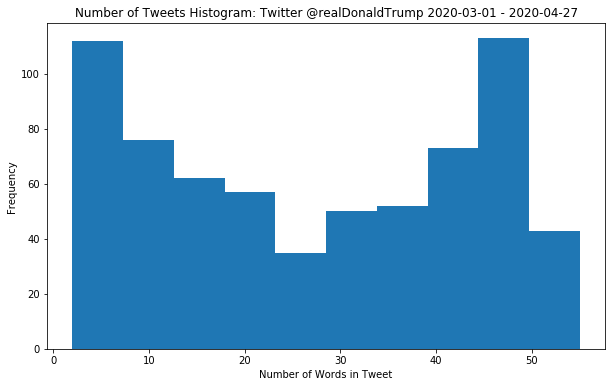

In [7]:
tweets_lens = all_tweets_df['text'].str.split().apply(lambda x: len(x))
print(tweets_lens.describe())
title = "Number of Tweets Histogram: Twitter @{} {} - {}".format(KEYWORD, BEGINDATE, ENDDATE)
tweets_lens.plot(kind='hist', figsize=(10,6), title=title)
plt.xlabel("Number of Words in Tweet")

## Text clean-up (preprocessing)

In [8]:
import nltk
from nltk.corpus import stopwords, wordnet 
from nltk.stem import WordNetLemmatizer

# Additional stop words to be removed from text
additional_stop_words=['twitter','com','pic','rt','via']

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def text_cleanup(text):  
    '''
    Text pre-processing
        return tokenized list of cleaned words
    '''
    # Convert to lowercase
    text_clean = text.lower()
    # Remove non-alphabet
    text_clean = re.sub(r'[^a-zA-Z]|(\w+:\/\/\S+)',' ', text_clean).split()    
    # Remove short words (length < 3)
    text_clean = [w for w in text_clean if len(w)>2]
    # Lemmatize text with the appropriate POS tag
    lemmatizer = WordNetLemmatizer()
    text_clean = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text_clean]
    # Filter out stop words in English 
    stops = set(stopwords.words('english')).union(additional_stop_words)
    text_clean = [w for w in text_clean if w not in stops]

    return text_clean
    
cleaned_tweets_df = all_tweets_df.copy(deep=True)
# parsing tweets 
cleaned_tweets_df['token'] = [text_cleanup(x) for x in all_tweets_df['text']]     

print ('Tweets cleanup done')

Tweets cleanup done


Extract bigrams which sometimes offer more meaningful insights of the text.

In [9]:
from nltk.util import ngrams

def word_grams(words, min=1, max=2):
    '''
    Build ngrams word list
    '''
    word_list = []
    for n in range(min, max):
        for ngram in ngrams(words, n):
            word_list.append(' '.join(str(i) for i in ngram))
    return word_list

# Generate bigram tokens
cleaned_tweets_df['bigram_token'] = [word_grams(x, min=2, max=3) for 
                     x in cleaned_tweets_df['token']]
cleaned_tweets_df[['text','token','bigram_token']].head(3)

,text,token,bigram_token
0,"WOW! Thank you, just landed, see everyone soon! #KAG2020pic.twitter.com/QGdfIsOp4u","[wow, thank, land, see, everyone, soon, kag, qgdfisop]","[wow thank, thank land, land see, see everyone, everyone soon, soon kag, kag qgdfisop]"
1,Departing for the Great State of North Carolina!pic.twitter.com/BjnyTnnHUt,"[depart, great, state, north, carolina, bjnytnnhut]","[depart great, great state, state north, north carolina, carolina bjnytnnhut]"
2,They are staging a coup against Bernie!,"[stag, coup, bernie]","[stag coup, coup bernie]"


## Word Count and Word Cloud

In [10]:
# Convert series to list for word count
tweets_text = [word for one_tweet in cleaned_tweets_df['token'] for word in one_tweet]

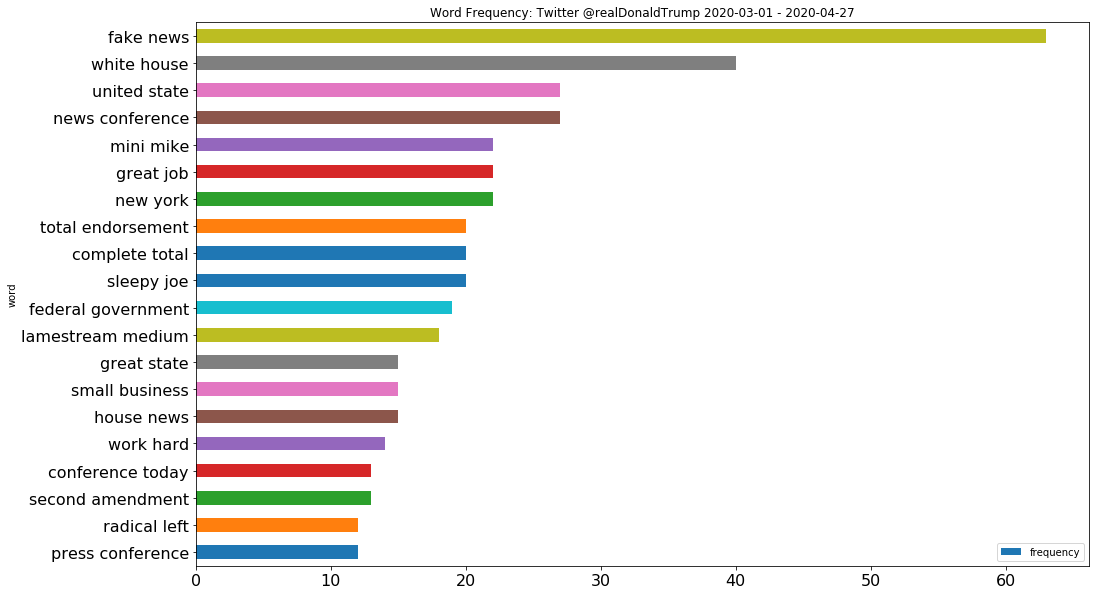

In [11]:
from collections import Counter

n_grams = list(ngrams(tweets_text, 2))
common_words = Counter(n_grams).most_common()
word_count = pd.DataFrame(data = common_words, columns=['word','frequency']) 
# Convert list to string
word_count['word'] = word_count['word'].apply(' '.join)

# Plot word count graph
title = "Word Frequency: Twitter @{} {} - {}".format(KEYWORD, BEGINDATE, ENDDATE)
word_count.head(20).sort_values('frequency').plot.barh(x='word', y='frequency', title=title,figsize=(16,10), fontsize=16)

In [12]:
word_count.head(20)

,word,frequency
0,fake news,63
1,white house,40
2,united state,27
3,news conference,27
4,mini mike,22
5,great job,22
6,new york,22
7,complete total,20
8,total endorsement,20
9,sleepy joe,20


(-0.5, 1599.5, 1199.5, -0.5)

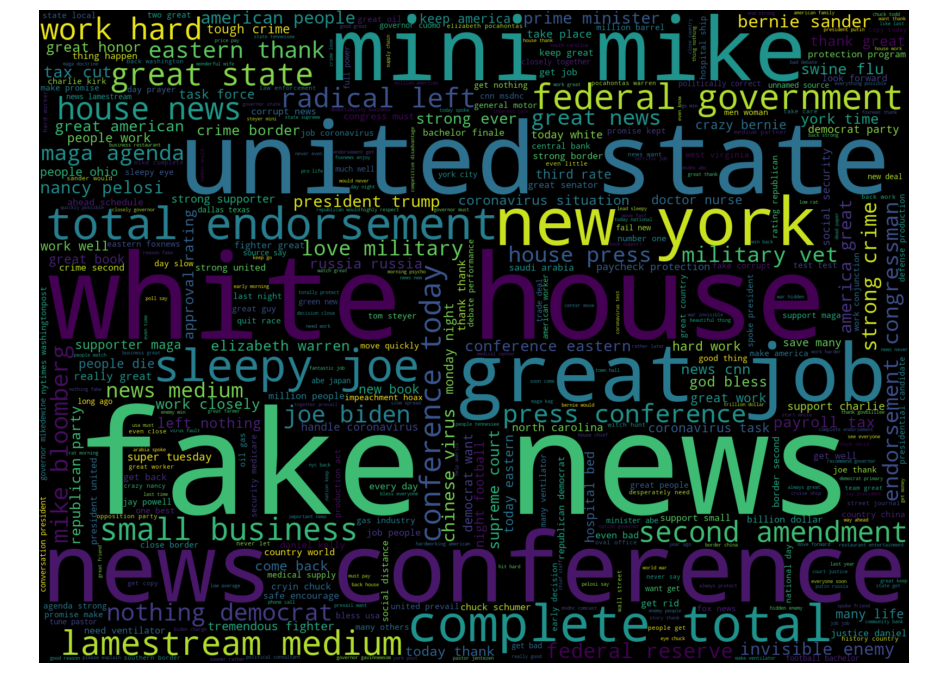

In [13]:
from wordcloud import WordCloud

# Convert DataFrame to map so that word cloud can be generated from freq
word_count_dict = {}
for w, f in word_count.values:
    word_count_dict[w] = f
# Generate word cloud 
wordcloud = WordCloud(max_words=400, width=1600, height=1200, 
                      random_state=12, contour_width=3,
                      contour_color='firebrick')
wordcloud.generate_from_frequencies(word_count_dict)    
plt.figure(figsize=(16,12)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

## Topic Modeling

In [19]:
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

Use unigrams for LDA training

In [20]:
# ----------------------
# LDA model hyper-parameters
# ----------------------
# Number of training passes
num_passes = 50 
# Document-Topic Density
alpha = 'auto'
# Word-Topic Density
eta = 'auto'

In [21]:
no_below = 10
no_above = 0.5

def build_corpus_dict(token_docs):
    docs_dict = corpora.Dictionary(token_docs)
    # Remove words that occur less than 10 documents or more than 50% of the doc
    docs_dict.filter_extremes(no_below, no_above)
    # Transform doc to a vectorized form by computing frequency of each word
    bow_corpus = [docs_dict.doc2bow(doc) for doc in token_docs]           
    # Create tf-idf model and then apply transformation to the entire corpus
    tfidf_corpus = models.TfidfModel(bow_corpus)[bow_corpus]

    return tfidf_corpus, docs_dict

In [22]:
def train_lda_model(num_topics, token_docs, tfidf_corpus, docs_dict):         
    # Train LDA model
    lda_model = models.ldamodel.LdaModel(corpus=tfidf_corpus, 
                                         num_topics=num_topics, 
                                         id2word=docs_dict, 
                                         passes=num_passes, 
                                         alpha=alpha, 
                                         eta=eta,
                                         random_state=49)
    
    # Evaluate LDA model performance by computing Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=token_docs, 
                                         dictionary=docs_dict, coherence='c_v')   
    coherence_value = coherence_model_lda.get_coherence()        
    print("Coherence value of", num_topics, "topics is", round(coherence_value,4))

    return lda_model, coherence_value

Search for the optimal number of topics to train LDA model

In [23]:
# Build dictionary
tfidf_corpus, docs_dict = build_corpus_dict(cleaned_tweets_df['token'])

In [24]:
# Range of number of topics 
start=2; limit=21; step=2;
print('Searching optimal number of topics for LDA model ...') 
coherence_values = []
model_list = []
for num_topics in range(start, limit, step):            
    lda_model, coherence_value = train_lda_model(num_topics, cleaned_tweets_df['token'], tfidf_corpus, docs_dict)
    model_list.append(lda_model)
    coherence_values.append(coherence_value)

Searching optimal number of topics for LDA model ...
Coherence value of 2 topics is 0.3175
Coherence value of 4 topics is 0.3721
Coherence value of 6 topics is 0.3306
Coherence value of 8 topics is 0.3718
Coherence value of 10 topics is 0.3595
Coherence value of 12 topics is 0.3627
Coherence value of 14 topics is 0.3368
Coherence value of 16 topics is 0.3259
Coherence value of 18 topics is 0.3378
Coherence value of 20 topics is 0.309


Text(0, 0.5, 'Coherence Value')

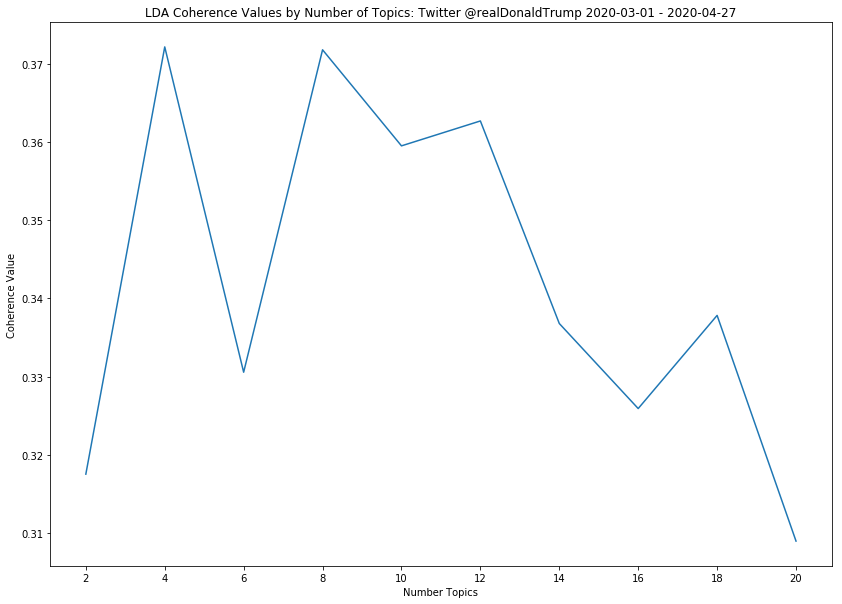

In [25]:
# Plot coherence values       
x = range(start, limit, step)   
plt.figure(figsize=(14,10))
title = "LDA Coherence Values by Number of Topics: Twitter @{} {} - {}".format(KEYWORD, BEGINDATE, ENDDATE)
plt.title(title)
plt.plot(x, coherence_values)
plt.xticks(x)
plt.xlabel("Number Topics")
plt.ylabel("Coherence Value")

Optimal number of topics is 8 which has the highest CV.

In [26]:
num_topics = 8
print('Starting LDA model training for', num_topics, 'topics') 
lda_model, coherence_value = train_lda_model(num_topics, cleaned_tweets_df['token'], tfidf_corpus, docs_dict)

Starting LDA model training for 8 topics
Coherence value of 8 topics is 0.3718


Gather all learned topics and give them a label using the top 4 keywords of the topic.

In [27]:
top_n_keywords = 4
topics_pd = pd.DataFrame() 
# Label topics using top 4 keywords of the topic
for idx, topic in lda_model.print_topics():
    topic_desc = '-'.join([x[0] for x in lda_model.show_topic(idx,top_n_keywords)])
    topics_pd = topics_pd.append(pd.Series([idx,topic_desc, topic]), ignore_index=True)        
topics_pd.columns = ['topic_num','topic_desc','topic_keywords']
topics_pd

,topic_num,topic_desc,topic_keywords
0,0.0,federal-government-full-test,"0.066*""federal"" + 0.059*""government"" + 0.037*""full"" + 0.033*""test"" + 0.030*""general"" + 0.026*""bill"" + 0.023*""hospital"" + 0.022*""low"" + 0.022*""know"" + 0.021*""continue"""
1,1.0,conference-white-news-house,"0.089*""conference"" + 0.085*""white"" + 0.082*""news"" + 0.081*""house"" + 0.072*""eastern"" + 0.056*""today"" + 0.039*""press"" + 0.036*""million"" + 0.032*""thank"" + 0.031*""world"""
2,2.0,thank-deal-great-call,"0.285*""thank"" + 0.053*""deal"" + 0.052*""great"" + 0.038*""call"" + 0.035*""company"" + 0.026*""act"" + 0.025*""leader"" + 0.024*""together"" + 0.021*""go"" + 0.021*""work"""
3,3.0,joe-bernie-mike-sleepy,"0.060*""joe"" + 0.057*""bernie"" + 0.056*""mike"" + 0.053*""sleepy"" + 0.049*""mini"" + 0.036*""biden"" + 0.033*""long"" + 0.032*""democrat"" + 0.030*""foxnews"" + 0.027*""also"""
4,4.0,fake-news-state-people,"0.022*""fake"" + 0.020*""news"" + 0.017*""state"" + 0.017*""people"" + 0.017*""get"" + 0.017*""country"" + 0.017*""united"" + 0.017*""say"" + 0.016*""time"" + 0.015*""medium"""
5,5.0,keep-total-complete-safe,"0.035*""keep"" + 0.034*""total"" + 0.034*""complete"" + 0.031*""safe"" + 0.029*""endorsement"" + 0.029*""small"" + 0.026*""strong"" + 0.026*""business"" + 0.025*""great"" + 0.024*""amendment"""
6,6.0,great-day-book-history,"0.107*""great"" + 0.043*""day"" + 0.039*""book"" + 0.038*""history"" + 0.032*""wonderful"" + 0.031*""hard"" + 0.031*""end"" + 0.029*""national"" + 0.028*""american"" + 0.027*""situation"""
7,7.0,kag-thank-ventilator-need,"0.162*""kag"" + 0.093*""thank"" + 0.067*""ventilator"" + 0.042*""need"" + 0.038*""spoke"" + 0.032*""good"" + 0.032*""help"" + 0.028*""every"" + 0.022*""deliver"" + 0.018*""work"""


Label each tweet with the most probable topic that is learned by LDA model.

In [28]:
docs_topic_dist = lda_model.get_document_topics(tfidf_corpus)
# Topic with the highest score i.e. most probable topic
docs_probable_topic_dist = [sorted(l,key=lambda x: x[1], reverse=True)[0] for l in docs_topic_dist]

# Get most probably topic number and probablity for each tweet
docs_topic = pd.DataFrame({'topic_num': [t[0] for t in docs_probable_topic_dist],
                           'probability': [t[1] for t in docs_probable_topic_dist]})
# Add topic label
docs_topic = docs_topic.merge(topics_pd[['topic_num','topic_desc']], how='left', on='topic_num') 

# Label tweets with topics
tweets_with_topic = pd.concat([docs_topic, cleaned_tweets_df[['token','text']]], axis=1, sort=False)
tweets_with_topic.head(10)

,topic_num,probability,topic_desc,token,text
0,6,0.508440,great-day-book-history,"[wow, thank, land, see, everyone, soon, kag, qgdfisop]","WOW! Thank you, just landed, see everyone soon! #KAG2020pic.twitter.com/QGdfIsOp4u"
1,6,0.583983,great-day-book-history,"[depart, great, state, north, carolina, bjnytnnhut]",Departing for the Great State of North Carolina!pic.twitter.com/BjnyTnnHUt
2,3,0.544840,joe-bernie-mike-sleepy,"[stag, coup, bernie]",They are staging a coup against Bernie!
3,2,0.539677,thank-deal-great-call,[thank],THANK YOU!https://www.breitbart.com/tech/2020/03/01/florida-am-student-donald-trump-deserves-credit-for-progress-at-historically-black-colleges/ …
4,5,0.808480,keep-total-complete-safe,"[michelle, fischbachmn, run, congress, minnesota, michelle, protect, unborn, strong, crime, border, cut, tax, love, military, vet, stand, great, farmer, michelle, complete, total, endorsement]","Michelle @FischbachMN7 is running for Congress in Minnesota. Michelle will protect the unborn, is Strong on Crime & Borders, Cutting Taxes, your #2A, Loves our Military, Vets, & will stand w/ our Great Farmers. Michelle has my Complete & Total Endorsement!https://secure.winred.com/MichelleFischbach/website-donations …"
5,5,0.589652,keep-total-complete-safe,"[congresswoman, kay, grangercampaign, work, hard, texas, strong, supporter, maga, agenda, strong, secure, border, pro, life, kay, complete, total, endorsement]",Congresswoman Kay @GrangerCampaign has worked hard for Texas and been a strong supporter of our #MAGA Agenda. She’s strong on #2A and Securing our Border and is 100% pro-life. Kay has my Complete and Total Endorsement!https://secure.winred.com/kaygranger/donate …
6,5,0.760330,keep-total-complete-safe,"[thank, billcassidy, support, maga, agenda, outstanding, job, represent, people, louisiana, complete, total, endorsement]",THANK YOU @BillCassidy for all of your support with our #MAGA Agenda. You are doing an outstanding job representing the people of Louisiana & the U.S.A. You have my Complete and Total Endorsement! #KAG2020https://twitter.com/BillCassidy/status/1230189738742685698 …
7,3,0.441271,joe-bernie-mike-sleepy,"[people, favor, mini, mike, continue, hapless, campaign, political, consultant, get, richer, richer, day]","The only people in favor of Mini Mike continuing with his hapless campaign are me and his political consultants, who are getting richer and richer by the day!"
8,4,0.802032,fake-news-state-people,"[foxnews, work, hard, push, radical, left, nothing, democrat, want, unlike, competitor, cnn, msdnc, comcast, fair, balance, ever, learn, radical, left, never, even, give, foxnews, permission, partake, low, rat, debate]",".@FoxNews is working hard pushing the Radical Left, Do Nothing Democrats. They want to be, unlike their competitors, @CNN & MSDNC (Comcast), Fair & Balanced. When will they ever learn. The Radical Left never even gave @FoxNews permission to partake in their low rated debates!"
9,4,0.336505,fake-news-state-people,"[competitive, disadvantage, lead, follow]","....competitive disadvantage. We should be leading, not following!"


Tweet topic distribution in percentage

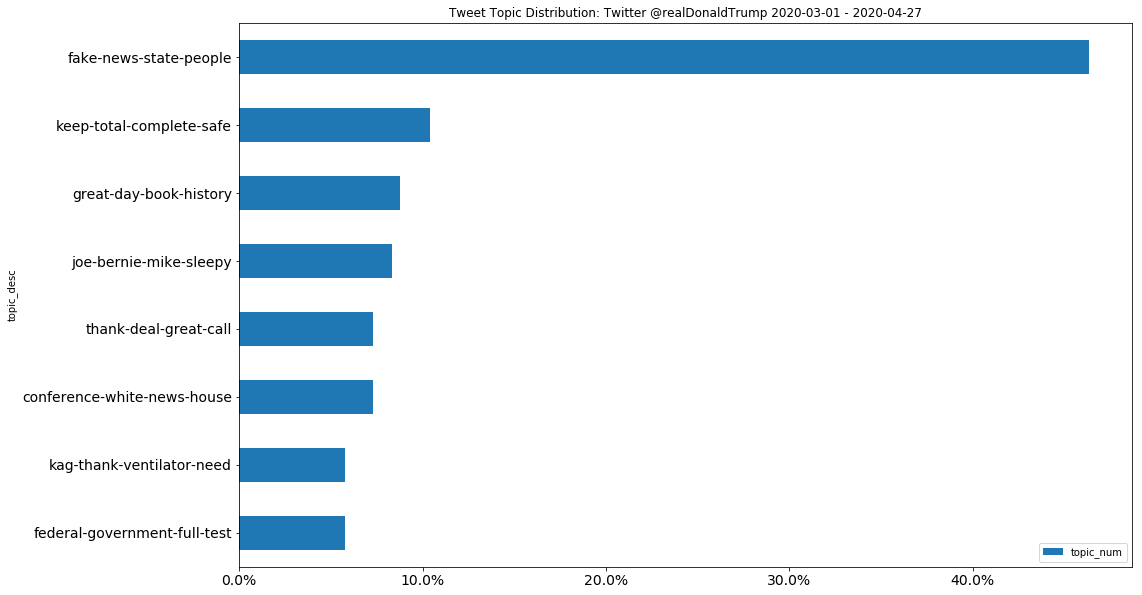

In [35]:
import matplotlib.ticker as mtick
topic_distribution = tweets_with_topic.groupby('topic_desc').count()[['topic_num']].sort_values(['topic_num'])/tweets_with_topic.shape[0]
title = "Tweet Topic Distribution: Twitter @{} {} - {}".format(KEYWORD, BEGINDATE, ENDDATE)
ax = topic_distribution.plot.barh(figsize=(16,10),fontsize=14, title=title)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))

In [36]:
topic_distribution.sort_values('topic_num', ascending=False)

,topic_num
topic_desc,
fake-news-state-people,0.463596
keep-total-complete-safe,0.104012
great-day-book-history,0.087667
joe-bernie-mike-sleepy,0.083210
conference-white-news-house,0.072808
thank-deal-great-call,0.072808
federal-government-full-test,0.057949
kag-thank-ventilator-need,0.057949


## Visualize Topics

In [23]:
import pyLDAvis.gensim
lda_data =  pyLDAvis.gensim.prepare(lda_model, tfidf_corpus, docs_dict, mds='mmds')
pyLDAvis.display(lda_data)